In [1]:
import numpy as np 
import random
from scipy.optimize import minimize
from sphere_decoding.sphereDecodingUseC import sphere_decoding_BER


# generate transmit signal
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = [np.array([qam16_modulation(bits_sequence[i+j]) for j in range(Nt)]) for i in range(0, len(bits_sequence), Nt)]
    return bits_sequence, x_sequence

def generate_noise(SNR, Nr):
    return np.sqrt(1/(2*SNR))*(np.random.randn(Nr,1)+1j*np.random.randn(Nr,1))

# generate training and tesing data
def generate_data(Nr,Nt,SNR_dB,length,H_channel):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    SNR= 10**(SNR_dB/10)
    n_sequence = [generate_noise(SNR, Nr) for i in range(length)]
    y_sequence = [np.dot(H_channel, x_sequence[i].reshape(Nt,1)) + n_sequence[i] for i in range(length)]
    return bits_sequence, x_sequence, y_sequence

def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)

def calculate_layer1(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    output = {}
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        error = y - np.dot(H_hat,s)
        value =  np.exp(-np.square(np.linalg.norm(error)))
        output[bits] = value
    return output

def calculate_layer2(layer1_output):
    sum_exp = [[0 for i in range(2)] for j in range(4*Nt)]
    for bits in layer1_output:
        value = layer1_output[bits]
        for index in range(4*Nt):
            sum_exp[index][eval(bits[index])] += value
    output = {}
    for index in range(4*Nt):
        # llr = np.log(sum_exp[index][1]/sum_exp[index][0])
        output[index] = (sum_exp[index][1])/(sum_exp[index][1]+sum_exp[index][0])
    return output

def calculate_cross_entropy(layer2_output, true_sequence):
    dimension = len(true_sequence)
    entropy = 0
    for index in range(dimension):
        if true_sequence[index] == '1':
            entropy += (-np.log(layer2_output[index]))
    return entropy

def calculate_square_error(layer2_output, true_sequence):
    dimension = len(true_sequence)
    loss = 0
    for index in range(dimension):
        if true_sequence[index] == '1':
            loss += np.square(1-layer2_output[index])
        else:
            loss += np.square(layer2_output[index])
    return loss

def calculate_cost_function(H_hat_vec):
    H_hat = H_hat_vec[0:Nr*Nt].reshape(Nr,Nt)+1j*H_hat_vec[Nr*Nt:2*Nr*Nt].reshape(Nr,Nt)
    # H_hat = H_hat_vec
    total_loss = 0
    training_length = len(y_sequence)
    for ii in range(training_length):
        layer1_output = calculate_layer1(H_hat, y_sequence[ii])
        layer2_output = calculate_layer2(layer1_output)
        true_sequence = ''.join(bits_sequence[ii*Nt+jj] for jj in range(Nt))
        total_loss += calculate_square_error(layer2_output,true_sequence)
    mean_loss = total_loss/training_length
    # print(mean_loss)
    return mean_loss
        
def detection(y, H_trained):
    layer1_output = calculate_layer1(H_trained, y)
    layer2_output = calculate_layer2(layer1_output)
    detect_result = ''
    for ii in range(len(layer2_output)):
        if(layer2_output[ii]>0.5):
            detect_result += '1'
        else:
            detect_result += '0'
    return(detect_result)

def count_differences(str1, str2):
    return sum(a != b for a, b in zip(str1, str2))


def training():
    H_hat_vec = np.sqrt(1/2)*(np.random.randn(Nr*Nt*2))

    out = minimize(calculate_cost_function, x0=H_hat_vec, method="COBYLA", options={'maxiter':100})

    H_hat_vec = out.x

    H_trained = H_hat_vec[0:Nr*Nt].reshape(Nr,Nt)+1j*H_hat_vec[Nr*Nt:2*Nr*Nt].reshape(Nr,Nt)
    
    return H_trained

def calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing):
    error = 0
    for ii in range(len(y_sequence_testing)):
        detect_result = detection(y_sequence_testing[ii], H_trained)
        true_sequence = ''.join(bits_sequence_testing[ii*Nt+jj] for jj in range(Nt))
        error += count_differences(detect_result, true_sequence)
    BER = error/(len(y_sequence_testing)*len(detect_result))
    return BER


# generate training and tesing data
Nt = 2
Nr = 4
# generate channel

iter_num = 3
SNR_list = np.array([0, 5, 10, 15, 20])

SD_mean_performance = np.zeros(len(SNR_list))
QNN_mean_performance = np.zeros(len(SNR_list))

H_list = [np.sqrt(1/2)*(np.random.randn(Nr,Nt)+1j*np.random.randn(Nr,Nt)) for ii in range(iter_num)]

for ii in range(len(SNR_list)):
    SNR_dB = SNR_list[ii]
    print("SNR_dB: "+str(SNR_dB))
    
    SD_performance = np.zeros(iter_num)
    QNN_performance = np.zeros(iter_num)

    for jj in range(iter_num):
        # print("current iter num: " +str(jj))
        H = H_list[jj]
        # print(H)
        bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,SNR_dB,1024,H)
        SD_performance[jj] = sphere_decoding_BER(H, y_sequence_testing, bits_sequence_testing, 0.1)
        print("SD: "+str(SD_performance[jj]))

        bits_sequence, x_sequence, y_sequence = generate_data(Nr,Nt,SNR_dB,128,H)
        H_trained = training()
        QNN_performance[jj] = calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing)
        print("QNN: "+str(QNN_performance[jj]))

    SD_mean_performance[ii] = np.mean(SD_performance)
    QNN_mean_performance[ii] = np.mean(QNN_performance)

print(SD_mean_performance)
print(QNN_mean_performance)

SNR_dB: 0
SD: 0.001708984375


KeyboardInterrupt: 

In [1]:
import numpy as np 
import random
from scipy.optimize import minimize
from sphere_decoding.sphereDecodingUseC import sphere_decoding_BER
import matplotlib.pyplot as plt
from timeit import default_timer as time


# generate transmit signal
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = [np.array([qam16_modulation(bits_sequence[i+j]) for j in range(Nt)]) for i in range(0, len(bits_sequence), Nt)]
    return bits_sequence, x_sequence

def generate_noise(SNR, Nr):
    return np.sqrt(1/(2*SNR))*(np.random.randn(Nr,1)+1j*np.random.randn(Nr,1))

# generate training and tesing data
def generate_data(Nr,Nt,SNR_dB,length,H_channel):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    SNR= 10**(SNR_dB/10)
    n_sequence = [generate_noise(SNR, Nr) for i in range(length)]
    y_sequence = [np.dot(H_channel, x_sequence[i].reshape(Nt,1)) + n_sequence[i] for i in range(length)]
    return bits_sequence, x_sequence, y_sequence

def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)

In [112]:
def calculate_layer1(H_hat):
    output = np.empty((Nt,16,Nr), dtype=np.complex128)
    for ii in range(Nt):
        h = H_hat[:,ii]
        for jj in range(16):
            s_j = h * qam16_modulation(str(bin(jj)[2:].zfill(4)))
            output[ii][jj] = s_j
    return output

def calculate_layer2(output_layer1, y):
    dimension = 2**(4*Nt)
    output = np.zeros(dimension)
    for index in range(dimension):
        s = np.zeros(Nr , dtype=np.complex128)
        binary_index = str(bin(index)[2:].zfill(4*Nt))
        for ii in range(Nt):
            j = int(binary_index[4*ii:4*ii+4], 2)
            s += output_layer1[ii][j]
        error = y - s.reshape(Nr,1)
        output[index] = np.exp(-np.square(np.linalg.norm(error)))
    return output

def calculate_layer3(layer2_output):
    sum_exp = np.zeros((4*Nt, 2))
    for index, prob in enumerate(layer2_output):
        bits = str(bin(index)[2:].zfill(4*Nt))
        for ii in range(4*Nt):
            sum_exp[ii][eval(bits[ii])] += prob
    output = np.empty((4*Nt))
    for ii in range(4*Nt):
        output[ii] = sum_exp[ii][1]/(sum_exp[ii][1]+sum_exp[ii][0])
    return output

def calculate_square_error(layer3_output, true_sequence):
    dimension = len(true_sequence)
    loss = 0
    for index in range(dimension):
        if true_sequence[index] == '1':
            loss += np.square(1-layer3_output[index])
        else:
            loss += np.square(layer3_output[index])
    return loss

In [109]:
H = np.random.randn(4,2)+1j*np.random.randn(4,2)
y = np.array([1,1,1,1],dtype=np.complex128).reshape(4,1)
Nt = 2
Nr = 4
bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,15,1024,H)






In [116]:
output1 = calculate_layer1(H)

output2 = calculate_layer2(output1, y_sequence_testing[0])

output3 = calculate_layer3(output2)


output3     

array([9.60661295e-01, 9.99999829e-01, 1.45473090e-02, 9.84961807e-01,
       4.37157367e-04, 8.72495423e-01, 8.41995182e-01, 7.35496986e-02])

In [3]:
def sensing_field_for_high_dimension(sensing_field_QAM, Nt):
    if Nt == 1:
        return sensing_field_QAM
    else:
        previous_sensing_field = sensing_field_for_high_dimension(sensing_field_QAM, Nt-1)
        new_sensing_field = []
        for ii in range(len(previous_sensing_field)):
            for jj in range(len(sensing_field_QAM)):
                new_sensing_field.append(previous_sensing_field[ii]+sensing_field_QAM[jj])
        return new_sensing_field

sensing_field_for_high_dimension(['1100','0111'], 4)

['1100110011001100',
 '1100110011000111',
 '1100110001111100',
 '1100110001110111',
 '1100011111001100',
 '1100011111000111',
 '1100011101111100',
 '1100011101110111',
 '0111110011001100',
 '0111110011000111',
 '0111110001111100',
 '0111110001110111',
 '0111011111001100',
 '0111011111000111',
 '0111011101111100',
 '0111011101110111']

In [42]:
def sensing_field_for_one_dimension(random_num):
    num = int(random_num/2)
    result = []
    ls = random.sample(range(8),num)
    for ii in range(num):
        result.append(bin(ls[ii])[2:].zfill(4))
        result.append(bin(15-ls[ii])[2:].zfill(4))
    return result


def sensing_field_for_high_dimension(Nt, random_num):
    if Nt == 1:
        return sensing_field_for_one_dimension(random_num)
    else:
        previous_sensing_field = sensing_field_for_high_dimension(Nt-1, random_num)
        this_dimension_sensing_field =  sensing_field_for_one_dimension(random_num)
        new_sensing_field = []
        for ii in range(len(previous_sensing_field)):
            for jj in range(random_num):
                new_sensing_field.append(previous_sensing_field[ii]+this_dimension_sensing_field[jj])
        return new_sensing_field

sensing_field_for_high_dimension(3, 4)

['011000100110',
 '011000101001',
 '011000100000',
 '011000101111',
 '011011010110',
 '011011011001',
 '011011010000',
 '011011011111',
 '011001110110',
 '011001111001',
 '011001110000',
 '011001111111',
 '011010000110',
 '011010001001',
 '011010000000',
 '011010001111',
 '100100100110',
 '100100101001',
 '100100100000',
 '100100101111',
 '100111010110',
 '100111011001',
 '100111010000',
 '100111011111',
 '100101110110',
 '100101111001',
 '100101110000',
 '100101111111',
 '100110000110',
 '100110001001',
 '100110000000',
 '100110001111',
 '001000100110',
 '001000101001',
 '001000100000',
 '001000101111',
 '001011010110',
 '001011011001',
 '001011010000',
 '001011011111',
 '001001110110',
 '001001111001',
 '001001110000',
 '001001111111',
 '001010000110',
 '001010001001',
 '001010000000',
 '001010001111',
 '110100100110',
 '110100101001',
 '110100100000',
 '110100101111',
 '110111010110',
 '110111011001',
 '110111010000',
 '110111011111',
 '110101110110',
 '110101111001',
 '110101110000

In [97]:
np.array([1,2,3])+np.array([0,1,0])

array([1, 3, 3])

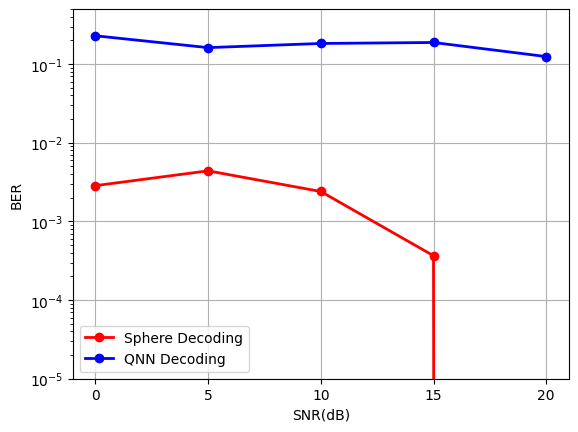

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(111)

lns1 = ax1.plot(SNR_list, SD_mean_performance, '-ro', linewidth=2.0, label="Sphere Decoding")
lns2 = ax1.plot(SNR_list, QNN_mean_performance, '-bo', linewidth=2.0, label="QNN Decoding")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
ax1.grid()

ax1.set_xticks(SNR_list)
ax1.set_yscale("log")
ax1.set_adjustable("datalim")
ax1.set_ylim(1e-5, 0.5)
ax1.set_ylabel("BER")
ax1.set_xlabel("SNR(dB)")


# plt.savefig('convergence.pdf',dpi=600, bbox_inches='tight')
plt.show()